In [1]:
#imports
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matminer.featurizers.composition import ElementProperty
from pymatgen import Composition
from camd.agent.base import HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.campaigns.base import Campaign
from camd.experiment.base import ATFSampler

from sklearn.linear_model import LinearRegression
import os
from monty.os import cd

## Data Prep

In [2]:
#load jcap data into a data frame
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner

jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df.shape

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:00<00:00, 165MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 35.8kB/s]


(100430, 45)

In [3]:
#define alloy system
Z = ['Ni', 'Mn']

#find all entries that have some amount of elements in Z
jcap_df = jcap_df[jcap_df.loc[:,Z[0]] > 0.0]
jcap_df = jcap_df[jcap_df.loc[:,Z[1]] > 0.0]

#total proportion of Z must be at least cutoff
cutoff = 0.50
jcap_df = jcap_df[jcap_df.loc[:,Z[0]] + jcap_df.loc[:,Z[1]] > 0.5]

#drop vae and spectrum, not used in model
jcap_df = jcap_df.drop('vae', axis=1)
jcap_df = jcap_df.drop('spectrum', axis=1)

#remove any elements that are not represented in data set
drop_list = []
for i in range(2,jcap_df.shape[1]):
    if not (np.any(jcap_df.iloc[:,i])):
        drop_list.append(jcap_df.iloc[:,i].name)
        
print("Dropping these elements from composition: \n", drop_list)
jcap_df = jcap_df.drop(drop_list, axis=1)

Dropping these elements from composition: 
 ['Sn', 'Ti', 'Zn', 'Ce', 'Cu', 'W', 'Mo', 'Cr', 'Y', 'Sr', 'Gd', 'Sb', 'Nb', 'Ga', 'Al', 'Pb', 'Mg', 'Pr', 'Zr', 'Ba', 'P', 'Sc', 'Ag', 'Tb', 'Pd', 'Hf', 'Rb']


In [4]:
#convert composition to a vector, ensure all add to 1
formula = []
for i in range(1,jcap_df.shape[1]):
    formula.append(jcap_df.iloc[:,i].name)

compositions = []
for i in range(jcap_df.shape[0]):
    compositions.append(np.array(jcap_df.iloc[i,1:]))
    
# jcap_df['composition'] = compositions
# jcap_df = jcap_df.drop(formula, axis=1)
jcap_df.head()

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd
comp_id,,,,,,,,,,,,,,,,
13225,2.425327,0.0,0.0,0.50,0.000,0.0,0.15,0.0,0.0,0.35,0.0,0.000,0.0,0.0,0.0,0.0
13226,2.409050,0.0,0.0,0.15,0.045,0.0,0.40,0.0,0.0,0.40,0.0,0.005,0.0,0.0,0.0,0.0
13227,2.302296,0.0,0.0,0.25,0.135,0.0,0.50,0.0,0.0,0.10,0.0,0.015,0.0,0.0,0.0,0.0
13229,2.231123,0.0,0.0,0.15,0.180,0.0,0.60,0.0,0.0,0.05,0.0,0.020,0.0,0.0,0.0,0.0
13230,2.437762,0.0,0.0,0.90,0.000,0.0,0.10,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0


In [5]:
#sort by bandgap value
jcap_df = jcap_df.sort_values("bandgap", ascending=True)
jcap_df.head()

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd
comp_id,,,,,,,,,,,,,,,,
93072,0.681642,0.4,0.0,0.5,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93059,0.704428,0.0,0.2,0.2,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93050,0.730551,0.2,0.1,0.4,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93187,0.735384,0.0,0.1,0.3,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93016,0.773443,0.3,0.1,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#prepare candidate and test datasets
k_seed_data = jcap_df.iloc[::2]
k_candidate_data = jcap_df.iloc[1::2]
# k_candidate_data = k_candidate_data.drop(['bandgap'], axis=1)
k_candidate_data.head()
print(k_seed_data.shape)
print(k_candidate_data.shape)

(2963, 16)
(2963, 16)


In [7]:
assert not set(k_seed_data.index).intersection(k_candidate_data.index)

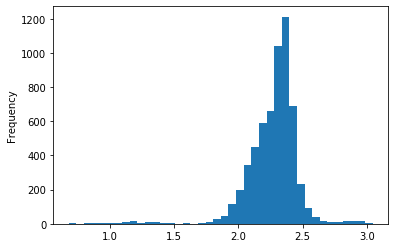

In [8]:
#bandgap histogram
jcap_df['bandgap'].plot.hist(bins=40)
target_val = 1.25

## Agent

In [9]:
def get_composition(dataframe):
    composition = [column for column in dataframe 
                      if len(column) == 2]
    return dataframe[composition]

In [10]:
#define agent
class LinearAgent(HypothesisAgent):
    def __init__(self, target_value):
        self.target_value = target_value
        
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = get_composition(seed_data)
        y_known = seed_data['bandgap']
        regressor = LinearRegression()
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = get_composition(candidate_data)
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        candidate_data['bandgap_pred'] = y_predicted
        candidate_data['target_diff'] = np.abs(y_predicted - self.target_value)
        candidate_data = candidate_data.sort_values(
            'target_diff', ascending=True)
        top_candidates = candidate_data.head(5)
        return top_candidates

In [11]:
#test agent
l_agent = LinearAgent(target_val)
hypotheses = l_agent.get_hypotheses(k_candidate_data, k_seed_data)
hypotheses

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd,bandgap_pred,target_diff
comp_id,,,,,,,,,,,,,,,,,,
92935,0.877384,0.2,0.1,0.5,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.248614,0.001386
93133,1.181461,0.2,0.1,0.6,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.258502,0.008502
92938,1.249217,0.0,0.4,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.226284,0.023716
92940,1.388607,0.2,0.1,0.2,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.218952,0.031048
93067,1.734150,0.0,0.4,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.216397,0.033603


## Experiment

In [12]:
#define experiment
k_atf_experiment = ATFSampler(dataframe=jcap_df)

In [13]:
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()
results

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd
comp_id,,,,,,,,,,,,,,,,
92935,0.877384,0.2,0.1,0.5,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93133,1.181461,0.2,0.1,0.6,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92938,1.249217,0.0,0.4,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92940,1.388607,0.2,0.1,0.2,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93067,1.734150,0.0,0.4,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analyzer

In [14]:
#define analyzer
class BandgapAnalyzer(AnalyzerBase):
    def analyze(self, new_experimental_results, seed_data):
        new_seed = pd.concat(
            [seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_bandgap = new_experimental_results.bandgap.mean()
        average_dataset_bandgap = new_seed.bandgap.mean()

        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_bandgap],
            "average_dataset_bandgap": [average_dataset_bandgap]
        })
        return summary, new_seed

In [15]:
k_analyzer = BandgapAnalyzer()
summary, new_seed = k_analyzer.analyze(results, k_seed_data)

In [16]:
summary

,average_new_bandgap,average_dataset_bandgap
0,1.286164,2.265456


In [17]:
#define campaign
# Set up folders
os.system('rm -rf test')
os.system('mkdir -p test')
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=jcap_df)
with cd('test'):
    campaign = Campaign(
        candidate_data=k_candidate_data, 
        seed_data=k_seed_data,
        agent=l_agent,
        experiment=k_atf_experiment,
        analyzer=k_analyzer
    )
    campaign.auto_loop(initialize=True)

Campaign initialization state: Agent LinearAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent LinearAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent LinearAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent LinearAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent LinearAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

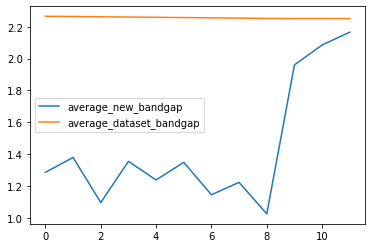

In [18]:
#visualize learning
history = pd.read_pickle('test/history.pickle')
history.plot()

In [19]:
print(target_val)
history

1.25


,average_new_bandgap,average_dataset_bandgap
0,1.286164,2.265456
1,1.379478,2.263966
2,1.096642,2.262006
3,1.355006,2.260486
4,1.238280,2.258776
5,1.348770,2.257255
6,1.145374,2.255401
7,1.223376,2.253683
8,1.025238,2.251641
9,1.960178,2.251157


In [20]:
_, result_history = k_atf_experiment.agg_history

In [23]:
k_candidate_data = k_candidate_data.drop(formula, axis=1)
k_candidate_data['bandgap_err'] = np.abs(k_candidate_data.bandgap - k_candidate_data.bandgap_pred)
k_candidate_data['real_target_diff'] = np.abs(k_candidate_data.bandgap - target_val)
k_candidate_data = k_candidate_data.sort_values("real_target_diff", ascending=True)
k_candidate_data.style.apply(
    lambda x: ['background: darkorange' 
               if (x.name in result_history.index)
               else '' for i in x], axis=1)

,bandgap,bandgap_pred,target_diff,bandgap_err
comp_id,,,,
93059,0.704428,1.669730,0.419730,0.965302
93187,0.735384,1.911228,0.661228,1.175843
92986,0.829866,1.921115,0.671115,1.091248
92935,0.877384,1.248614,0.001386,0.371231
93109,0.901216,1.358198,0.108198,0.456982
93089,0.938948,1.499999,0.249999,0.561051
92968,0.978880,1.348311,0.098311,0.369431
93086,0.996921,1.679617,0.429617,0.682696
93033,1.017334,1.116700,0.133300,0.099366
